In [1]:
!pip install tensorflow tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.4.1 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.4.1


In [2]:
!pip install opencv-python matplotlib

In [3]:
#Import Standard Dependencies
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import tensorflow dependence
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# Avoid OOM error by setting GpU 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.exxperimental.set_memory_growth(gpu, True)

In [6]:
len(gpus)

0

In [7]:
# setup Paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [8]:
# Make the directories
os.makedirs(POS_PATH , exist_ok=True)
os.makedirs(NEG_PATH , exist_ok=True)
os.makedirs(ANC_PATH , exist_ok=True)

In [9]:
!tar -xf lfw.tgz

In [10]:
# Move lfw_deepfuuneled image in data/negative
# Move lfw_deepfunneled image in data/negative
for directory in os.listdir('lfw_funneled'):
    directory_path = os.path.join('lfw_funneled', directory)
    if os.path.isdir(directory_path):  # Check if it's a directory
        for file in os.listdir(directory_path):
            EX_PATH = os.path.join(directory_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [11]:
for directory in os.listdir('data/negative'):
    dir_path = os.path.join('data/negative', directory)
    if os.path.isdir(dir_path):  # Check if it's a directory
        for file in os.listdir(dir_path):
            print(os.path.join(dir_path, file))  # Use dir_path as the base


In [12]:
#import uuid library to generate unique images names
import uuid

In [13]:
uuid.uuid1()

UUID('f4e965be-999e-11ef-b8cc-28cdc474f354')

In [14]:
# Collect Positive and Anchor Classes
cap = cv2.VideoCapture(0)   # for camera to connect with system
while cap.isOpened(): #it keep camera to open in loop
    
    ret,frame = cap.read()# in this it store the image
    # cut down frame to 250x250
    frame = frame[120:120+250,200:200+250]
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):    # it show when we press a is anchor images collect and how long it work
        # Create the unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out the anchor image
        cv2.imwrite(imgname,frame)
        
            
    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):    # it show when we press p is positive images collect and how long it work
        # Create the unique file paths
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out the positive images
        cv2.imwrite(imgname, frame)

    
            
    cv2.imshow('Image Collection',frame)    #it show the image
    if cv2.waitKey(1) & 0XFF == ord('q'):    # it show when we press q is quit and how long it work
        break

# Release the webcame
cap.release()
# close the image show frame
cv2.destroyAllWindows()

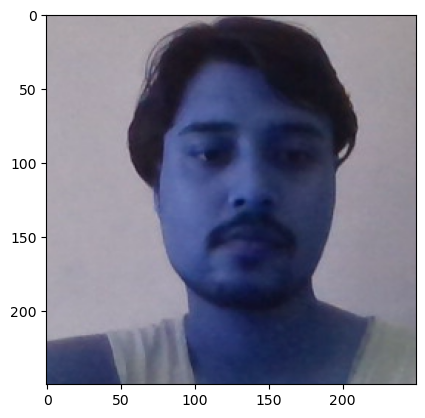

In [15]:
plt.imshow(frame)

In [16]:
frame.shape

(250, 250, 3)

# Load And Preprocess Images
1.1 Get Image Directories

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(700) # this hold the address, size and items, like file paths, images, or other data points
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(700)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(700)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\DELL\AppData\Local\Temp\ipykernel_16472\2671420181.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(700) # this hold the address, size and items, like file paths, images, or other data points
C:\Users\DELL\AppData\Local\Temp\ipykernel_16472\2671420181.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(700)
C:\Users\DELL\AppData\Local\Temp\ipykernel_16472\2671420181.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(700)


In [19]:
ANC_PATH+'\*.jpg'

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
C:\Users\DELL\AppData\Local\Temp\ipykernel_16472\3189626913.py:1: SyntaxWarning: invalid escape sequence '\*'
  ANC_PATH+'\*.jpg'


'data\\anchor\\*.jpg'

In [20]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\d3660331-992d-11ef-8f37-28cdc474f354.jpg'

# 3.2 Preprocessing - Scale and Resize

In [22]:
def preprocess(file_path):
    # Read in image file path
    byte_img = tf.io.read_file(file_path)
    # Load in the images
    img = tf.io.decode_jpeg(byte_img)

    #Preprocessing steps - resizing the images to be 100x100x3
    img = tf.image.resize(img,(100,100))
    # Scaling image to be between 0 and 1
    img = img / 255.0

    #Return image
    return img

In [23]:
img = preprocess('data\\anchor\\fa910065-9994-11ef-8eee-28cdc474f354.jpg')

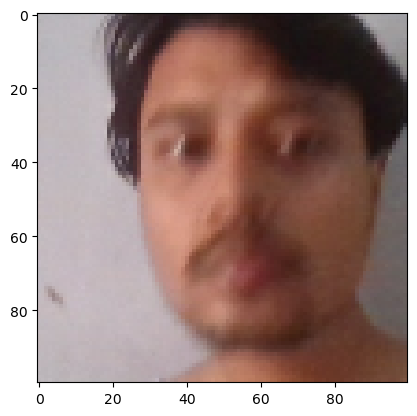

In [24]:
plt.imshow(img)

In [25]:
img.numpy().max()

0.87671566

# 3.3 Create Labelled Dataset

In [27]:
#tf.data.Dataset.zip will run all three together and then result code slices the data in [0,0,0,0,0] and [1,1,1,1,1]
positive = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive.concatenate(negative)

In [28]:
sample = data.as_numpy_iterator()

In [29]:
example = sample.next()

In [30]:
example

(b'data\\anchor\\f6a84e26-992d-11ef-9fb4-28cdc474f354.jpg',
 b'data\\positive\\3becc92d-9995-11ef-8d9a-28cdc474f354.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [32]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [33]:
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.74240196, 0.7463235 , 0.7620098 ],
         [0.73970586, 0.7436274 , 0.7593137 ],
         [0.7441176 , 0.7480392 , 0.7637255 ],
         ...,
         [0.72181374, 0.7375    , 0.7473039 ],
         [0.71887255, 0.7345588 , 0.7384804 ],
         [0.72156864, 0.7372549 , 0.7411765 ]],
 
        [[0.7509804 , 0.75784314, 0.7647059 ],
         [0.74607843, 0.7529412 , 0.7617647 ],
         [0.7377451 , 0.7512255 , 0.7637255 ],
         ...,
         [0.71960783, 0.7352941 , 0.7392157 ],
         [0.71666664, 0.7323529 , 0.7362745 ],
         [0.722549  , 0.7382353 , 0.74215686]],
 
        [[0.7441176 , 0.75980395, 0.7637255 ],
         [0.74019605, 0.7558824 , 0.76029414],
         [0.73995095, 0.7556372 , 0.76593137],
         ...,
         [0.7257353 , 0.7348039 , 0.7409314 ],
         [0.71838236, 0.73406863, 0.7379902 ],
         [0.7235294 , 0.7392157 , 0.74313724]],
 
        ...,
 
        [[0.70906866, 0.7169118 

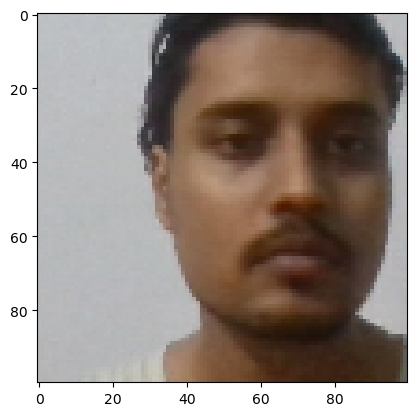

In [34]:
plt.imshow(res[0])

In [35]:
res[2]

1.0

In [36]:
# Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
sample=data.as_numpy_iterator()

In [38]:
samp = sample.next()

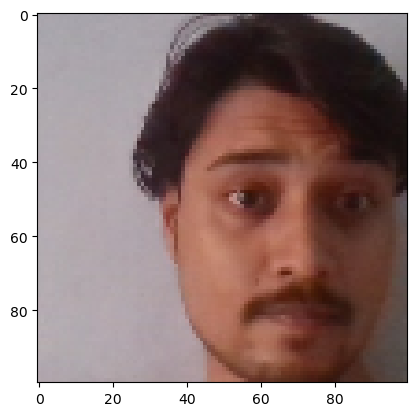

In [39]:
plt.imshow(samp[0])

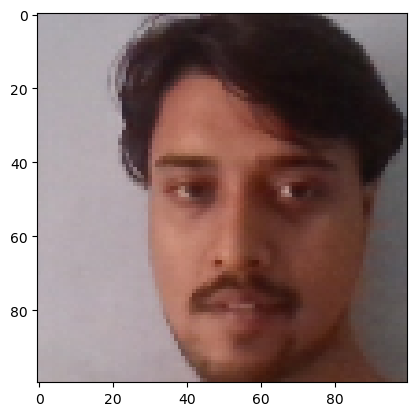

In [40]:
plt.imshow(samp[1])

In [41]:
samp[2]

1.0

In [42]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [43]:
# Training partition 
train_data = data.take(round(len(data)*.7)) # this mean we taking 70 of data from table data.take is use for taking the data
train_data = train_data.batch(16) # that means we sending the data in 16 batch
train_data = train_data.prefetch(8) # that mean we we raedy to give second batch before the first batch complete so that gpu no need to wait for long

In [44]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [45]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [46]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4 Model Engineering
#### 4.1 Build Embedding Layer

In [48]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_img')

    #first Block
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding = 'same')(c1)

    #second Block
    c2 = Conv2D(128,(7,7),activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)

    # Final embedding Block
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation = 'sigmoid')(f1)


    return Model(inputs =[inp], outputs=[d1], name='embedding')

In [49]:
embedding = make_embedding()

In [50]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Build Distance Layer

In [52]:
# Siammese l1 distance

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        # Ensure inputs are tensors, not lists
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        # Calculate L1 distance
        return tf.math.abs(input_embedding - validation_embedding)


In [53]:
l1 = L1Dist()

In [54]:
 #l1(anchor_embedding, validation_embedding)
l1

<L1Dist name=l1_dist, built=False>

### 4.3 Make Siamese Model

In [56]:
def make_siamse_model():
    
    #Handle inputs
    #Anchor image input in the network
    input_image = Input(name = 'input_img', shape=(100,100,3))

    #validation images in the network
    validation_image = Input(name = 'validation_img', shape=(100,100,3))

    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #classification layer
    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier, name= 'SiameseNetwork')
    

In [57]:
siamese_model = make_siamse_model()

In [58]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training

#### 5.1 Setup Loss and Optimizer

In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [62]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

#### 5.2 Establish Checkpoints

In [64]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### 5.3 Build Train Step Function

In [66]:
import tensorflow as tf

@tf.function
def train_step(batch):
    # Unpack batch data
    X, y = batch[:2], batch[2]  # Ensure your batch has this format

    with tf.GradientTape() as tape:
        # Generate predictions
        y_pred = siamese_model(X, training=True)  # Obtain model output with training mode enabled
        
        # Reshape `y_pred` if necessary; ensure it matches the shape of `y`
        y_pred = tf.reshape(y_pred, [-1])  # This is a common shape, adjust based on your actual use case
        
        # Calculate the loss
        loss = binary_cross_loss(y, y_pred)

    # Print or log the loss if desired
    tf.print("Loss:", loss)

    # Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Update weights if gradients are not None
    if grad is not None:
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

    

#### 5.4 Build Training Loop

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))  # Display epoch info
        progbar = tf.keras.utils.Progbar(len(data))  # Progress bar


        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step
            train_step(batch)
            progbar.update(idx + 1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)



#### 5.5 Train the model

In [75]:
EPOCHS = 50

In [77]:
train(train_data, EPOCHS)


Epoch 1/50
Loss: 0.693140507
 1/62 ━━━━━━━━━━━━━━━━━━━━ 7:13 7s/stepLoss: 0.685798049
 2/62 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/stepLoss: 0.660822034
 3/62 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/stepLoss: 0.632253289
 4/62 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/stepLoss: 0.554491937
 5/62 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/stepLoss: 0.672481239
 6/62 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/stepLoss: 0.642629385
 7/62 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/stepLoss: 0.576452613
 8/62 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/stepLoss: 0.55389905
 9/62 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/stepLoss: 0.474990666
10/62 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/stepLoss: 0.477283835
11/62 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/stepLoss: 0.420920163
12/62 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/stepLoss: 0.585940123
13/62 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/stepLoss: 0.347335517
14/62 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/stepLoss: 0.349148691
15/62 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/stepLoss: 0.36995247
16/62 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/stepLoss: 0.42569682
17/62 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/stepLoss: 0.354490906
18/6

## 6. Evaluate Model

In [79]:
# Import metric calcualtion
from tensorflow.keras.metrics import Precision , Recall

In [81]:
#Get a batch of test data and if we want to change the batch
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [83]:
y_true

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [85]:
# Make soe prediction
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[1.0000000e+00],
        [9.9241219e-14],
        [2.9453796e-12],
        [1.0000000e+00],
        [8.7014996e-07],
        [9.9994814e-01],
        [1.0000000e+00],
        [2.0599214e-15],
        [3.7654617e-15],
        [2.9571227e-08],
        [9.9999988e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.8772302e-14],
        [5.0767905e-08]]], dtype=float32)

In [86]:
# Post processing the result
# Assuming y_hat is a list or array of predictions
[1 if pred > 0.5 else 0 for pred in y_hat.flatten()]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]

In [87]:
y_true

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [88]:
# creating a metric object
m =Recall()
#calculating the recall value
m.update_state(y_true,y_hat)
# return recall Result
m.result().numpy()


1.0

In [89]:
# creating a metric object
n =Precision()
#calculating the recall value
n.update_state(y_true,y_hat)
# return recall Result
n.result().numpy()

1.0

#### 6.4 Viz Results

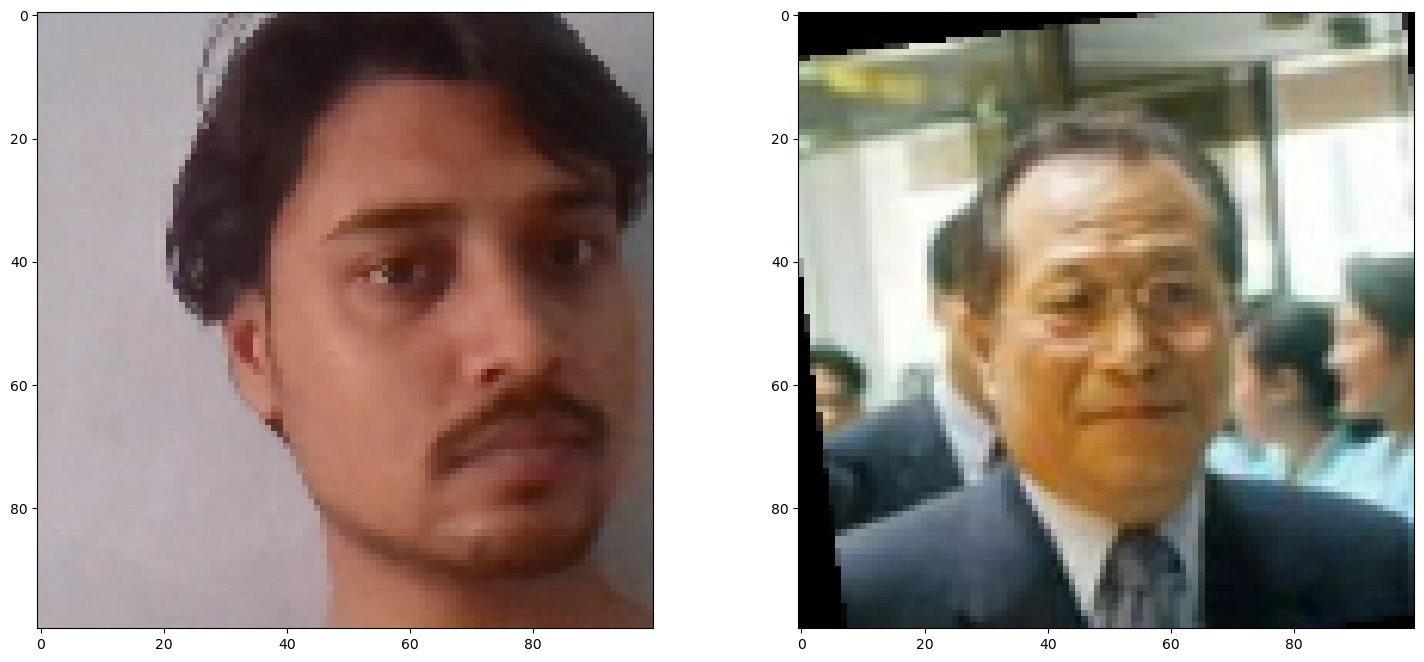

In [91]:
# set plot size
plt.figure(figsize=(18,8))
#Set first subplot
plt.subplot(1,2,1) # subplot(nrows, ncols, index, **kwargs) 1- row,2-cols, 1- my side images
plt.imshow(test_input[1])
# control the second subplot
plt.subplot(1,2,2) # 1- row 2- columns 2- mean king side images
plt.imshow(test_val[1])

#Render images
plt.show()

In [95]:
plt.subplot??

Signature: plt.subplot(*args, **kwargs) -> 'Axes'
Docstring:
Add an Axes to the current figure or retrieve an existing Axes.

This is a wrapper of `.Figure.add_subplot` which provides additional
behavior when working with the implicit API (see the notes section).

Call signatures::

   subplot(nrows, ncols, index, **kwargs)
   subplot(pos, **kwargs)
   subplot(**kwargs)
   subplot(ax)

Parameters
----------
*args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
    The position of the subplot described by one of

    - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
      *index* position on a grid with *nrows* rows and *ncols* columns.
      *index* starts at 1 in the upper left corner and increases to the
      right. *index* can also be a two-tuple specifying the (*first*,
      *last*) indices (1-based, and including *last*) of the subplot, e.g.,
      ``fig.add_subplot(3, 1, (1, 2))`` makes a subplot that spans the
      upper 2/3 of the figu

## Save Model

In [99]:
# save the weights
siamese_model.save('siamesemodel.h5')

In [100]:
# Reload model -> tf.keras.model.load_model this is model the save model
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [102]:
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[1.0000000e+00],
        [9.9241219e-14],
        [2.9453796e-12],
        [1.0000000e+00],
        [8.7014996e-07],
        [9.9994814e-01],
        [1.0000000e+00],
        [2.0599214e-15],
        [3.7654617e-15],
        [2.9571227e-08],
        [9.9999988e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.8772302e-14],
        [5.0767905e-08]]], dtype=float32)

In [104]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 8 .Real time Test

### 8.1 Verification Function

In [108]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))

        #Make Prediction
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

    #Detection threshold: Metric above with a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    #Verfication Threshold : Proportion of positive predictions / total positive samples
    verification = detection/ len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold


    return results, verified
    

    
    

### 8.2 OpenCV Real Time Verification

In [112]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 200:200+250]
    cv2.imshow('Verification', frame)

    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        # Save frame for verification
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run Verification
        results, verified = verify(model, 0.6, 0.5)
        print(verified)

    elif key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()



    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━

In [113]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)